Nel Dataset ci sono: 3309 istanze
HAEMATOCRIT     0
HAEMOGLOBINS    0
ERYTHROCYTE     0
LEUCOCYTE       0
THROMBOCYTE     0
MCH             0
MCHC            0
MCV             0
AGE             0
SEX             0
SOURCE          0
dtype: int64


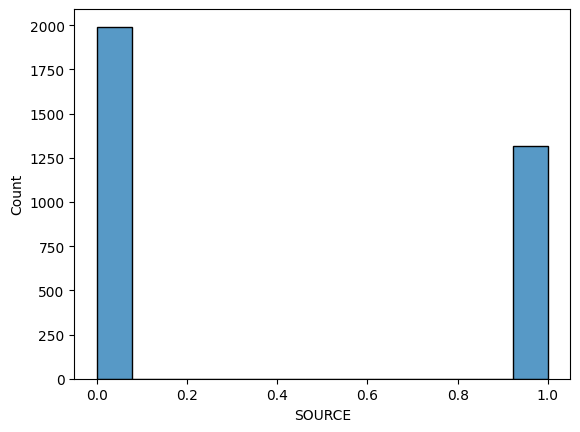

0    1992
1    1317
Name: SOURCE, dtype: int64
95


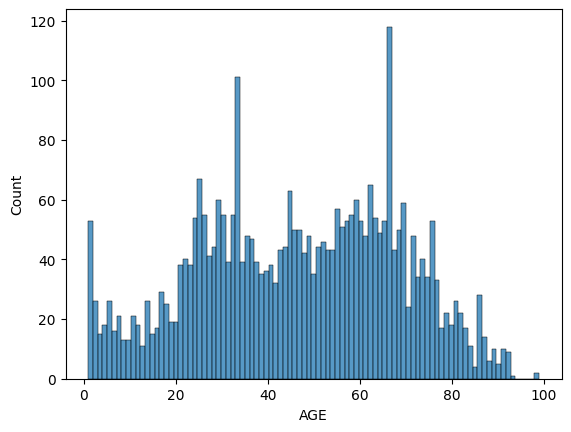

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('training_set.csv')
print('Nel Dataset ci sono:',df.shape[0], 'istanze')
print(df.isna().sum())
sns.histplot(df, x='SOURCE')
plt.show()
print(df['SOURCE'].value_counts())
print(df['AGE'].value_counts().size)
sns.histplot(df, x='AGE', bins=95)
plt.show()

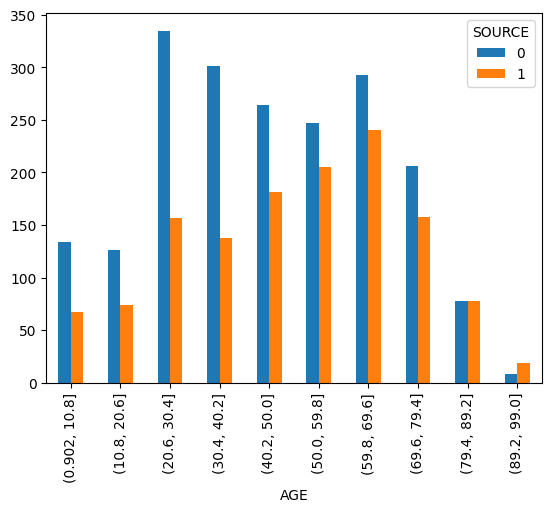

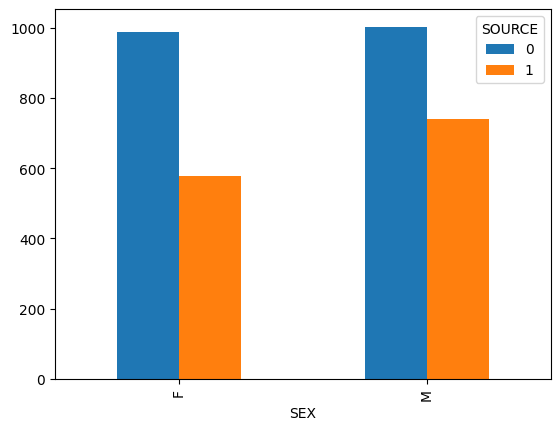

In [77]:
age_bin = df.copy()
age_bin['AGE'] = pd.cut(x=df['AGE'], bins=10)
temp = age_bin.groupby(['AGE', 'SOURCE'])
temp.size().unstack().plot.bar()
plt.show()

temp = age_bin.groupby(['SEX', 'SOURCE'])
temp.size().unstack().plot.bar()
plt.show()

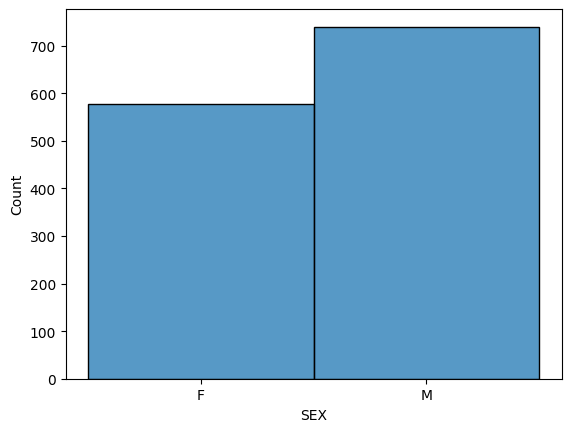

In [78]:
df_sick = df[df['SOURCE'] == 1]
sns.histplot(df_sick, x='SEX')
plt.show()

<AxesSubplot:xlabel='AGE'>

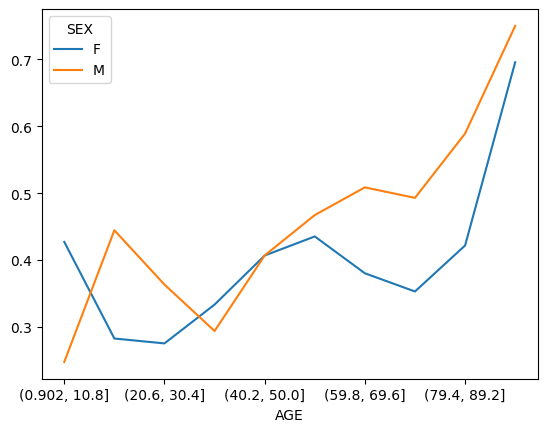

In [79]:
table = pd.pivot_table(age_bin, values='SOURCE', index='AGE', columns='SEX')
table.plot()

Predizione decision tree Test: 0.642792384406165 Train: 1.0
Predizione logistic regression Test: 0.7262012692656392 Train: 0.7189483227561196


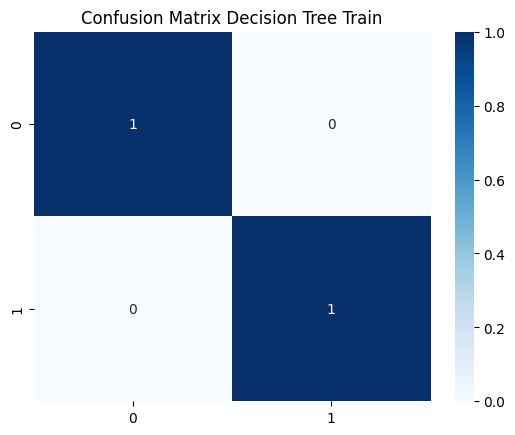

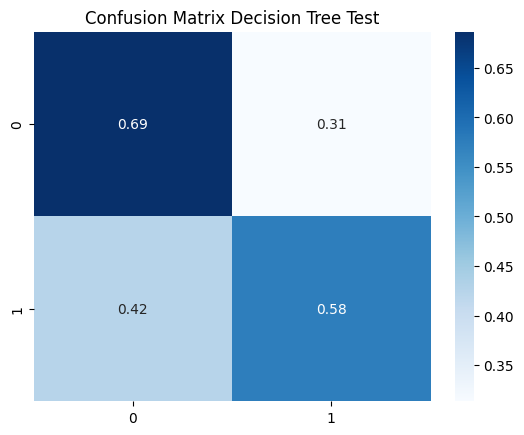

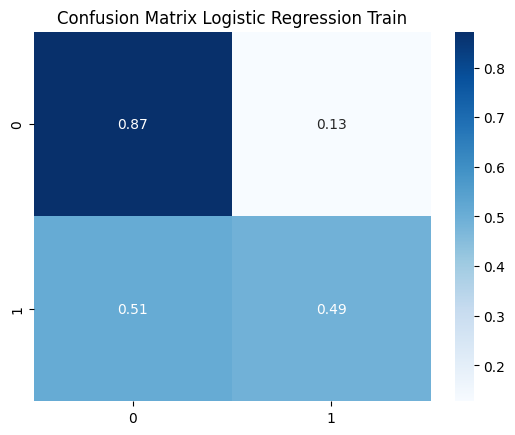

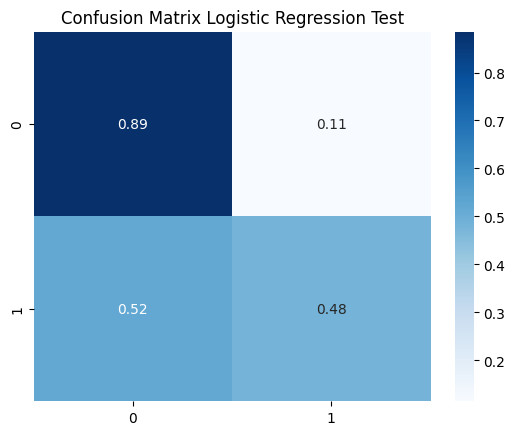

Predizione dummy Test: 0.6074342701722575 Train: 0.599274705349048


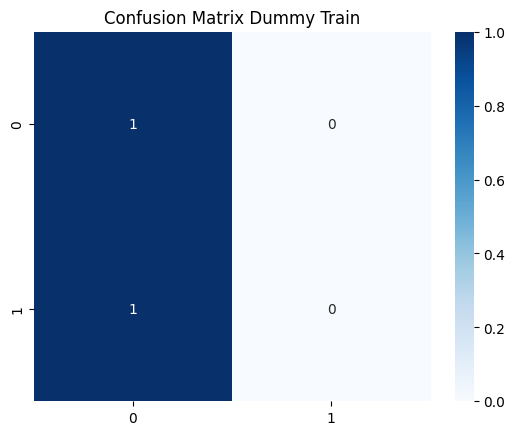

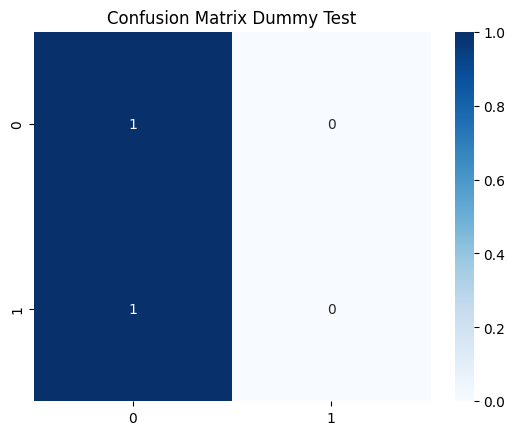

In [80]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('training_set.csv')
maps = {
    'M' : 1,
    'F' : 0
}
df = df.replace(maps)
y = df['SOURCE']
X = df.drop('SOURCE', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=1/3, random_state=0)

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train, y_train)

test_pred1 = logreg.predict(X_test)
train_pred1 = logreg.predict(X_train)
print(f'Predizione logistic regression Test: {accuracy_score(y_test, test_pred1)} Train: {accuracy_score(y_train, train_pred1)}')
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred, normalize='true', labels=tree.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred, normalize='true', labels=tree.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Decision Tree Test')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred1, normalize='true', labels=logreg.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred1, normalize='true', labels=logreg.classes_), annot=True, cmap='Blues')
plt.title('Confusion Matrix Logistic Regression Test')
plt.show()

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

test_pred2 = dummy.predict(X_test)
train_pred2 = dummy.predict(X_train)
print(f'Predizione dummy Test: {accuracy_score(y_test, test_pred2)} Train: {accuracy_score(y_train, train_pred2)}')
sns.heatmap(confusion_matrix(y_true=y_train, y_pred=train_pred2, normalize='true'), annot=True, cmap='Blues')
plt.title('Confusion Matrix Dummy Train')
plt.show()
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=test_pred2, normalize='true'), annot=True, cmap='Blues')
plt.title('Confusion Matrix Dummy Test')
plt.show()

In [81]:
print(f'Predizione Tree Test: {cross_val_score(tree, X, y, cv=10).mean()}')
print(f'Predizione Logistic Regression Test: {cross_val_score(logreg, X, y, cv=10).mean()}')
print(f'Predizione Dummy Test: {cross_val_score(dummy, X, y, cv=10).mean()}')

Predizione Tree Test: 0.6615307150050354
Predizione Logistic Regression Test: 0.7174356861668041
Predizione Dummy Test: 0.6019948732033324


In [82]:
from sklearn.model_selection import GridSearchCV

param = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', None],
    'min_samples_split' : [2,3,4,5,10]
}

gs = GridSearchCV(tree, param, scoring='accuracy', verbose=1)
gs.fit(X_train, y_train)

print(gs.best_params_)
test_pred = gs.predict(X_test)
train_pred = gs.predict(X_train)

print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'criterion': 'log_loss', 'max_features': None, 'min_samples_split': 3}
Predizione decision tree Test: 0.6364460562103355 Train: 0.9941069809610155


In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, MaxAbsScaler

trasformers = [
    ('discr', KBinsDiscretizer(n_bins=2), ['AGE', 'THROMBOCYTE'])
]

ct = ColumnTransformer(transformers=trasformers, remainder='passthrough')
Xd = ct.fit_transform(X)

scaler = MaxAbsScaler()

Xd = scaler.fit_transform(Xd)
X_train, X_test, y_train, y_test = train_test_split(Xd, y , test_size=1/3, random_state=0)

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)
test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)
print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.5983680870353582 Train: 1.0


In [84]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

trasformers = [
    ('discr_age', KBinsDiscretizer(n_bins=4, encode='ordinal'), ['AGE']),
    ('discr_thr', KBinsDiscretizer(n_bins=10, encode='ordinal'), ['THROMBOCYTE'])
]

ct = ColumnTransformer(transformers=trasformers, remainder='passthrough')
prepro = Pipeline(steps=[
    ('ct', ct),
    ('scaler', MinMaxScaler(feature_range=(0,1))),
    ('norm', Normalizer())
])

Xp = prepro.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(Xp, y , test_size=1/3, random_state=0)

tree.fit(X, y)
test_pred = tree.predict(X_test)
train_pred = tree.predict(X_train)

print(f'Predizione decision tree Test: {accuracy_score(y_test, test_pred)} Train: {accuracy_score(y_train, train_pred)}')

Predizione decision tree Test: 0.6074342701722575 Train: 0.599274705349048


In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear = LinearRegression()

linear.fit(X_train, y_train)

test_pred = linear.predict(X_test)
train_pred = linear.predict(X_train)
print(f'Accuracy Linear Regression Test: {mean_absolute_error(y_test, test_pred)} Train {mean_absolute_error(y_train, train_pred)}')

Accuracy Linear Regression Test: 0.4008604127847998 Train 0.3975168075328423


In [86]:
param = {
    'fit_intercept' : [True, False],
    'n_jobs' : [1,2,3,4,5]
}

gs = GridSearchCV(linear, param, scoring='accuracy', verbose=1)
gs.fit(X, y)

print(gs.best_params_)
print(f'Cross val score linear regression: {cross_val_score(gs,X,y).mean()}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'fit_intercept': True, 'n_jobs': 1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross val score linear regression: nan


In [89]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

pipe = FeatureUnion(transformer_list=[
    ('pipeline', prepro),
    ('pca', PCA(n_components=2)),
    ('kbest', SelectKBest(k=2))
])

Xk = pipe.fit_transform(X,y)
print(pd.DataFrame(Xk, columns=pipe.get_feature_names_out()))

      pipeline__discr_age__AGE  pipeline__discr_thr__THROMBOCYTE  \
0                     0.285200                          0.095067   
1                     0.193315                          0.193315   
2                     0.510665                          0.453924   
3                     0.000000                          0.352485   
4                     0.170502                          0.511505   
...                        ...                               ...   
3304                  0.194210                          0.000000   
3305                  0.000000                          0.000000   
3306                  0.489913                          0.381044   
3307                  0.167451                          0.390720   
3308                  0.632418                          0.210806   

      pipeline__remainder__HAEMATOCRIT  pipeline__remainder__HAEMOGLOBINS  \
0                             0.310987                           0.413635   
1                            